# Analysing Lapped Transforms

[Nils Werner](https://www.audiolabs-erlangen.de/fau/assistant/werner) and [Bernd Edler](https://www.audiolabs-erlangen.de/fau/professor/edler)

[International Audio Laboratories Erlangen](https://www.audiolabs-erlangen.de/)

In [ ]:
import numpy as np
import scipy as sp
import scipy.signal as ss
import scipy.linalg
import skimage.util
import matplotlib.pyplot as plt
import itertools

from utils import *

## Modified Discrete Cosine Transform

In this notebook, we will specifically investigate the [MDCT](https://en.wikipedia.org/wiki/Modified_discrete_cosine_transform), which is defined as

$$
X_k = \sum_{n=0}^{2N-1} h(n) x_n \cos \left[\frac{\pi}{N} \left(n+\frac{1}{2}-\frac{N}{2}\right) \left(k+\frac{1}{2}\right) \right] \qquad k \in 0, \dots, N-1
$$

however, looking at this definition, almost none of the unique attributes of the transform are readily visible, i.e.

 - how is this transform related to DCT-IV?
 - why is this transform orthogonal?
 - why is the choice of window function $h(n)$ important for perfect reconstruction?
 - how and when can we exchange $h(n)$?

### Polyphase Matrices

If instead we use the polyphase matrix notation as introduced in [2]

$$
\mathbf{D} = {\left(\cos\left[\frac{\pi}{N}\left(n + \frac{1}{2}\right)\left(k + \frac{1}{2}\right)\right]\right)}_{\substack{n=0,\dots,N-1 \\ k=0,\dots,N-1}} \in \mathbb{R}^{N \times N}
$$

$$
\newcommand\iddots{\mathinner{
  \raise1pt{.}
  \raise3pt{.}
  \raise5pt{.}
}}
\mathbf{F}(z) = \begin{bmatrix}
& & h\left(\frac{1}{2} N - 1\right)z^{-1} & h\left(\frac{1}{2} N\right)z^{-1} \\
& \iddots & & & \ddots \\
h\left(0\right)z^{-1} & & & & & h\left(N - 1\right)z^{-1} \\
h\left(N\right) & & & & & -h\left(2N - 1\right) \\
& \ddots & & & \iddots \\
& & h\left(\frac{3}{2} N - 1\right) & -h\left(\frac{3}{2} N\right) \\
\end{bmatrix} \in \mathbb{R}{(z)}^{N \times N}
$$

transform operations become matrix products (and thus notation becomes simpler)

$$
\vec{X}(z) = \mathbf{D} \; \mathbf{F}(z) \; \vec{x}(z)
$$

and we can start to see some of the properties emerge:

 - We can see that the MDCT is actually some pre-permutation between two frames (expressed in $z$-Domain, where $z^{-1}$ references the previous frame), followed by a DCT-IV.
 - We see that only if $h(n)$ fulfills some certain conditions (the Princen-Bradley-condition), $\mathbf{F}(z)$ is orthogonal.
 - We can see that (disregarding causality or delay) both $\mathbf{D}$ and $\mathbf{F}(z)$ are orthogonal, which means

$$
\vec{x}(z) = \mathbf{F}(z)^{T} \; \mathbf{D}^{T} \; \vec{X}(z)
$$

However, these matrices are still a little bit difficult to understand, and are **not suitable for usage in NumPy**.

# Representing Polyphase Matrices in NumPy

We will demonstrate how we can reformulate the previous matrices into blockdiagonal matrices that allow us to inspect the transform using NumPy.

Note that the definitions of `dct4`, `mdct`, `freq` and `env` are all in `utils.py`. Look at that file for their definitions.

## Single Frame

In this section, we will investigate how the MDCT will analyse a single signal frame.

Note that any lapped transform always requires more than one frame to synthesize the output signal ($\mathbf{F}(z)^{T}$ always has at least one $z^{-n}$ term with nonzero $n$), this means this single-frame analysis is only useful for learning about basic transform properties. It cannot be used to actually transform signals, or to analyze how two frames interact when being transformed (which is exactly the motivation for this publication [1]).

### MDCT Folding Behaviour

Since the MDCT is directly related to the [DCT-IV](https://en.wikipedia.org/wiki/Discrete_cosine_transform#DCT-IV), we can immediately get the folding behaviour of the MDCT by multiplying it with the inverse DCT-IV.

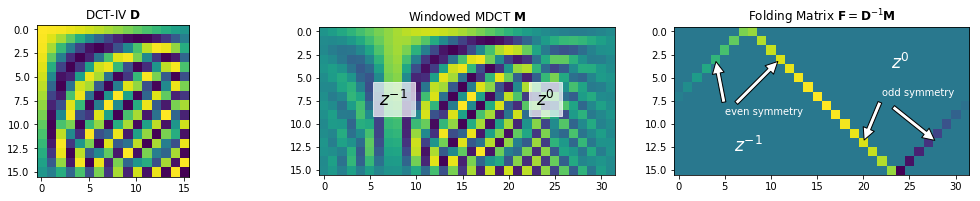

In [ ]:
D = dct4(16)
M = mdct(16) * ss.cosine(32)
P = D.T @ M


f, (a, b, c) = plt.subplots(1, 3, figsize=(18, 2.8))
a.imshow(D)
a.set_title("DCT-IV $\mathbf{D}$")
b.imshow(M)
b.set_title("Windowed MDCT $\mathbf{M}$")
c.imshow(P)
c.set_title("Folding Matrix $\mathbf{F} = \mathbf{D}^{-1}\mathbf{M}$")

b.annotate('$z^{-1}$', xy=(6, 8), color='black', backgroundcolor=(1, 1, 1, 0.7), fontsize='xx-large')
b.annotate('$z^{0}$', xy=(23, 8), color='black', backgroundcolor=(1, 1, 1, 0.7), fontsize='xx-large')

c.annotate('even symmetry', xy=(4, 3), xytext=(5, 9), color='white', arrowprops={'facecolor': 'white', 'shrink': 0.05})
c.annotate('', xy=(11, 3), xytext=(6, 8), arrowprops={'facecolor': 'white', 'shrink': 0.05})

c.annotate('odd symmetry', xy=(20, 12), xytext=(22, 7), color='white', arrowprops={'facecolor': 'white', 'shrink': 0.05})
c.annotate('', xy=(28, 12), xytext=(23, 8), arrowprops={'facecolor': 'white', 'shrink': 0.05})

c.annotate('$z^{-1}$', xy=(6, 13), color='white', fontsize='xx-large')
c.annotate('$z^{0}$', xy=(23, 4), color='white', fontsize='xx-large')

None

The result is a sparse matrix that immediately reveals the nature of the time domain aliasing introduced by MDCT:

 - The first and last quarter is folded ontop the second and third quarter, respectively
 - The first half has an even symmetry (equal sign)
 - The second half has an odd symmetry (different sign)

However, these matrices are **not square**, so no inverse exists and we cannot synthesize a time-domain signal from this.

## Multiple Frames

To better understand how two frames interact when transformed using MDCT, we can extend our transform matrices to process more than frame at once:

A matrix that transforms multiple frames individually is just a blockdiagonal matrix with the individual transforms on the main diagonal. We can very easily construct a block diagonal transform using multiple DCT-IV (Figure 1), then create folding matrix that folds adjacent frames (Figure 2), and create a multiple frame MDCT matrix by multiplying the two matrices (Frame 3).

In theory, for an infinite signal, this matrix would be infinitely large of course.

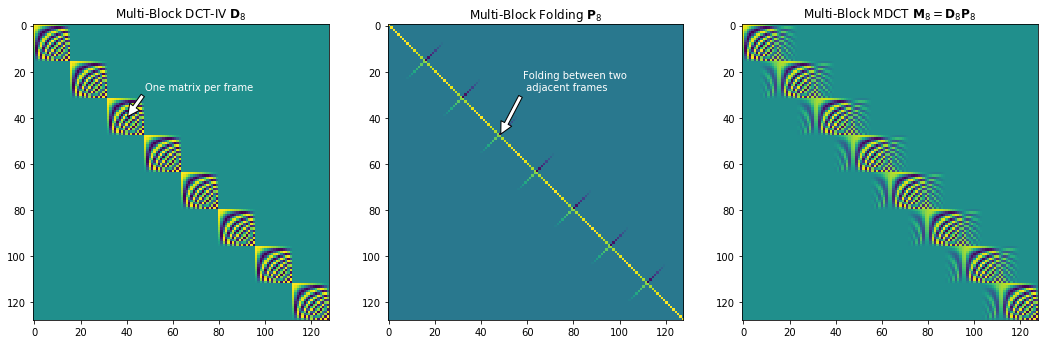

In [ ]:
D = dct4(16)
M = mdct(16) * ss.cosine(32)
P = D.T @ M

D8 = scipy.linalg.block_diag(*[D] * 8)
tmp = make_twoframe(P, trim=True)
P8 = scipy.linalg.block_diag(np.eye(8), *[tmp] * 7, np.eye(8))
M8 = D8 @ P8

fig, (a, b, c) = plt.subplots(1, 3, figsize=(18, 12))
a.imshow(D8)
a.set_title("Multi-Block DCT-IV $\mathbf{D}_8$")
b.imshow(P8)
b.set_title("Multi-Block Folding $\mathbf{P}_8$")
c.imshow(M8)
c.set_title("Multi-Block MDCT $\mathbf{M}_8 = \mathbf{D}_8 \mathbf{P}_8$")

a.annotate('One matrix per frame', xy=(40, 40), xytext=(48, 28), color='white', arrowprops={'facecolor': 'white', 'shrink': 0.05})
b.annotate('Folding between two \n adjacent frames', xy=(48, 48), xytext=(58, 28), color='white', arrowprops={'facecolor': 'white', 'shrink': 0.05})

None

## Two Frames

To get a closer look into how two frames interact when transformed using MDCT, we can limit our transform matrices to process two frames at once.

Basically we are extracting two DCT-IV matrices, and the folding matrix that affects the two.

It will later turn out that these matrices can also be used to transform an actual real-world signal.

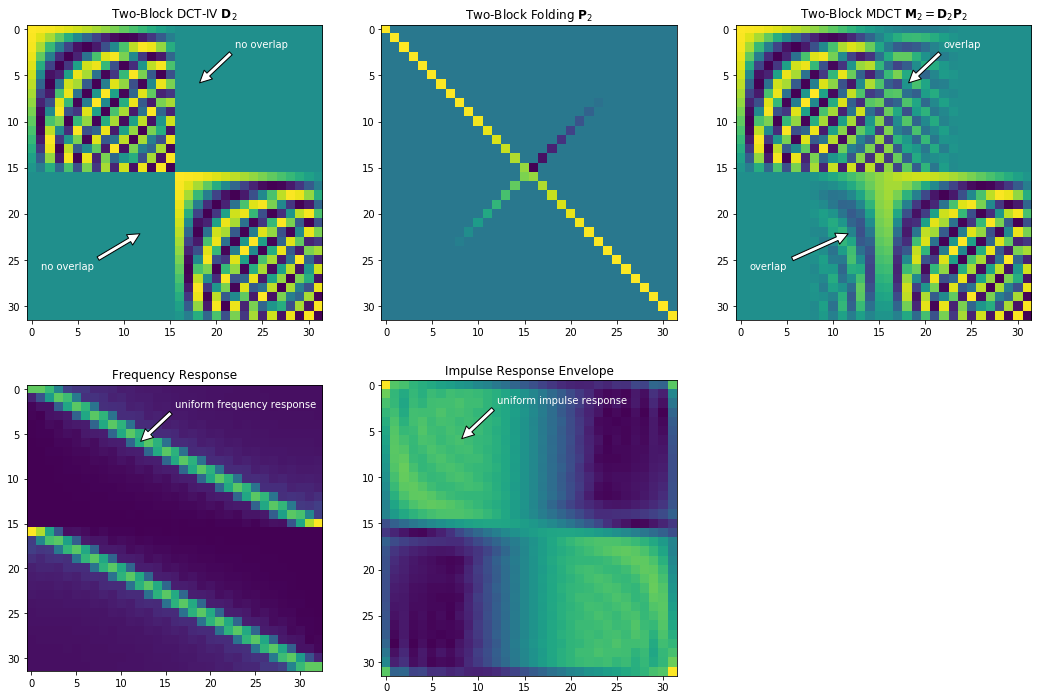

In [ ]:
D = dct4(16)
M = mdct(16) * ss.cosine(32)
P = D.T @ M

D2 = scipy.linalg.block_diag(D, D)
P2 = make_twoframe(P)
M2 = D2 @ P2


fig, ((a, b, c), (d, e, f)) = plt.subplots(2, 3, figsize=(18, 12))
a.imshow(D2)
a.set_title("Two-Block DCT-IV $\mathbf{D}_2$")
b.imshow(P2)
b.set_title("Two-Block Folding $\mathbf{P}_2$")
c.imshow(M2)
c.set_title("Two-Block MDCT $\mathbf{M}_2 = \mathbf{D}_2 \mathbf{P}_2$")
d.imshow(freq(M2))
d.set_title("Frequency Response")
e.imshow(env(M2))
e.set_title("Impulse Response Envelope")
f.set_visible(False)

a.annotate('no overlap', xy=(18, 6), xytext=(22, 2), color='white', arrowprops={'facecolor': 'white', 'shrink': 0.05})
a.annotate('no overlap', xy=(12, 22), xytext=(1, 26), color='white', arrowprops={'facecolor': 'white', 'shrink': 0.05})
c.annotate('overlap', xy=(18, 6), xytext=(22, 2), color='white', arrowprops={'facecolor': 'white', 'shrink': 0.05})
c.annotate('overlap', xy=(12, 22), xytext=(1, 26), color='white', arrowprops={'facecolor': 'white', 'shrink': 0.05})

d.annotate('uniform frequency response', xy=(12, 6), xytext=(16, 2), color='white', arrowprops={'facecolor': 'white', 'shrink': 0.05})
e.annotate('uniform impulse response', xy=(8, 6), xytext=(12, 2), color='white', arrowprops={'facecolor': 'white', 'shrink': 0.05})

None

In the last two plots we can easily observe two critical properties of the transform:
    
 1. Each filter in each frame has a distinct frequency response center, and they're all of same width
 1. The impulse responses in each frame are roughly in the same position, and they're all of same width
    
In other words: This filterbank is **uniform**.

## Invertibility

One crucial attribute of the MDCT is orthogonality and perfect reconstruction. Using the matrices we have created so far, we can also verify this property. For a few selected windows (rectangular, Kaiser-Bessel-derived, or cosine), this matrix is orthogonal, and for an incompatible window (i.e. Hann), it is not.

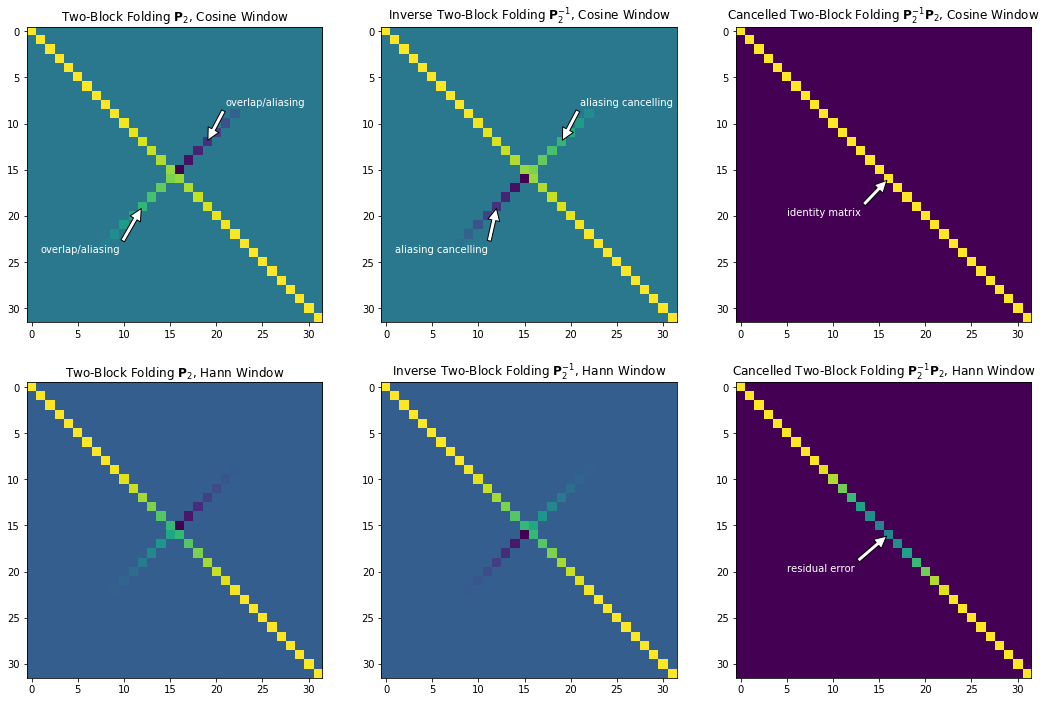

In [ ]:
iM = mdct(16) * ss.hann(32)
iP = D.T @ iM

iP2 = make_twoframe(iP)
iM2 = D2 @ iP2


fig, ((a, b, c), (d, e, f)) = plt.subplots(2, 3, figsize=(18, 12))
a.imshow(P2)
a.set_title("Two-Block Folding $\mathbf{P}_2$, Cosine Window")
b.imshow(P2.T)
b.set_title("Inverse Two-Block Folding $\mathbf{P}_2^{-1}$, Cosine Window")
c.imshow(P2.T @ P2)
c.set_title("Cancelled Two-Block Folding $\mathbf{P}^{-1}_2 \mathbf{P}_2$, Cosine Window")

d.imshow(iP2)
d.set_title("Two-Block Folding $\mathbf{P}_2$, Hann Window")
e.imshow(iP2.T)
e.set_title("Inverse Two-Block Folding $\mathbf{P}_2^{-1}$, Hann Window")
f.imshow(iP2.T @ iP2)
f.set_title("Cancelled Two-Block Folding $\mathbf{P}^{-1}_2 \mathbf{P}_2$, Hann Window")

a.annotate('overlap/aliasing', xy=(19, 12), xytext=(21, 8), color='white', arrowprops={'facecolor': 'white', 'shrink': 0.05})
a.annotate('overlap/aliasing', xy=(12, 19), xytext=(1, 24), color='white', arrowprops={'facecolor': 'white', 'shrink': 0.05})

b.annotate('aliasing cancelling', xy=(19, 12), xytext=(21, 8), color='white', arrowprops={'facecolor': 'white', 'shrink': 0.05})
b.annotate('aliasing cancelling', xy=(12, 19), xytext=(1, 24), color='white', arrowprops={'facecolor': 'white', 'shrink': 0.05})

c.annotate('identity matrix', xy=(16, 16), xytext=(5, 20), color='white', arrowprops={'facecolor': 'white', 'shrink': 0.05})
f.annotate('residual error', xy=(16, 16), xytext=(5, 20), color='white', arrowprops={'facecolor': 'white', 'shrink': 0.05})


None

# Nonuniform Transforms

Cascaded filterbanks to generate non-uniform orthogonal transforms [4,5] can be easily implemented and analysed, too. In this framework, Subband Merging is yet another matrix with transforms on the main diagonal.

Because we are inspecting more than one frame at once, we can, in theory, also design and investigate lapped or aliasing-reduced subband merging as introduced in [6]. For simplicity sake these will be skipped here, however.

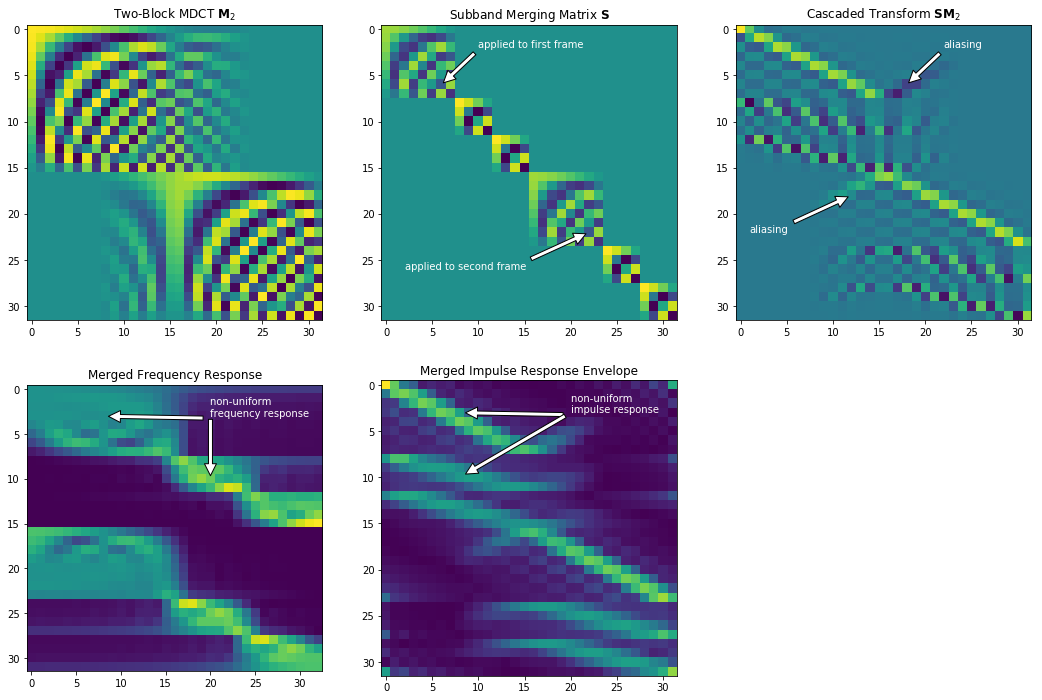

In [ ]:
mfs = np.array([8, 4, 4])
S = scipy.linalg.block_diag(*([dct4(m) for m in mfs] * 2))


fig, ((a, b, c), (d, e, f)) = plt.subplots(2, 3, figsize=(18, 12))
a.imshow(M2)
a.set_title("Two-Block MDCT $\mathbf{M}_2$")
b.imshow(S)
b.set_title("Subband Merging Matrix $\mathbf{S}$")
c.imshow(S @ M2)
c.set_title("Cascaded Transform $\mathbf{S} \mathbf{M}_2$")
d.imshow(freq(S @ M2))
d.set_title("Merged Frequency Response")
e.imshow(env(S @ M2))
e.set_title("Merged Impulse Response Envelope")
f.set_visible(False)

b.annotate('applied to first frame', xy=(6, 6), xytext=(10, 2), color='white', arrowprops={'facecolor': 'white', 'shrink': 0.05})
b.annotate('applied to second frame', xy=(22, 22), xytext=(2, 26), color='white', arrowprops={'facecolor': 'white', 'shrink': 0.05})

c.annotate('aliasing', xy=(18, 6), xytext=(22, 2), color='white', arrowprops={'facecolor': 'white', 'shrink': 0.05})
c.annotate('aliasing', xy=(12, 18), xytext=(1, 22), color='white', arrowprops={'facecolor': 'white', 'shrink': 0.05})

d.annotate('non-uniform \nfrequency response', xy=(8, 3), xytext=(20, 3), color='white', arrowprops={'facecolor': 'white', 'shrink': 0.05})
d.annotate('', xy=(20, 10), xytext=(20, 3), arrowprops={'facecolor': 'white', 'shrink': 0.05})

e.annotate('non-uniform \nimpulse response', xy=(8, 3), xytext=(20, 3), color='white', arrowprops={'facecolor': 'white', 'shrink': 0.05})
e.annotate('', xy=(8, 10), xytext=(20, 3), arrowprops={'facecolor': 'white', 'shrink': 0.05})

None

In the last two plots we can observe two new properties of the transform:
    
 1. In each frame, more than one filter share about the same frequency response center, the're much wider, and they're of different widths (proportional to the merge factor in this band)
 1. In each frame, the impulse responses are now in new positions, the're much more narrow, and they're of different widths (proportional to the merge factor in this band)
    
In other words: This transform is **non-uniform**

What we can also see in subplots 3 and 4 is a significant amount of **aliasing**. The method introduced in [3] can be used to cancel this aliasing. Again, this method can be implemented as a square polyphase matrix.

# References

 1. Werner, Nils and Edler, Bernd, "[Experimenting with Lapped Transforms in Numerical Computation Libraries using Polyphase Matrices and Strided Memory Views](http://www.aes.org/e-lib/browse.cfm?elib=20381)". Audio Engineering Society Convention 146, 2019
 1. Schuller, G. D. T. and Smith, M. J. T., "[New framework for modulated perfect reconstruction filter banks](https://ieeexplore.ieee.org/document/533715)". IEEE Transactions on Signal Processing, 44(8), pp. 1941–1954, 1996, ISSN 1053-587X, doi:10.1109/78.533715.
 1. Werner, Nils and Edler, Bernd, "[Nonuniform Orthogonal Filterbanks Based on MDCT Analysis/Synthesis and Time-Domain Aliasing Reduction](ieeexplore.ieee.org/document/7870593/)". IEEE Signal Processing Letters, 24(5): 589–593, 2017.
 1. H. S. Malvar, "[Biorthogonal and nonuniform lapped transforms for transform coding with reduced blocking and ringing artifacts](https://ieeexplore.ieee.org/document/668555)", IEEE Transactions on Signal Processing, Bd. 46, Nr. 4, S. 1043–1053, Apr. 1998.
 1. O. A. Niamut und R. Heusdens, "[Subband merging in cosine-modulated filter banks](https://ieeexplore.ieee.org/document/1186767)", IEEE Signal Processing Letters, Bd. 10, Nr. 4, S. 111–114, Apr. 2003.